In [28]:
import numpy as np
import pandas as pd
import time
import urllib.request
import io
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, _tree
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [29]:
def load_breast_cancer_data(url='https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'):
    """
    Loads and preprocesses the breast cancer dataset from URL

    Returns:
    --------
    tuple: (features, target, feature_names)
    """
    try:
        # Download data from URL
        response = urllib.request.urlopen(url)
        data = response.read().decode('utf-8')

        # Create DataFrame
        columns = ["ID", "Diagnosis"] + [f"Feature_{i}" for i in range(1, 31)]
        df_wdbc = pd.read_csv(io.StringIO(data), header=None, names=columns)

        # Data preprocessing
        df_wdbc.drop("ID", axis=1, inplace=True)
        df_wdbc["Diagnosis"] = df_wdbc["Diagnosis"].map({"M": 1, "B": 0})

        # Separate features and target variable
        X = df_wdbc.drop("Diagnosis", axis=1).values
        y = df_wdbc["Diagnosis"].values
        feature_names = df_wdbc.drop("Diagnosis", axis=1).columns.tolist()

        return X, y, feature_names
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

In [30]:
def visualize_confusion_matrices(conf_matrices, title):
    """
    Visualizes confusion matrices and calculates performance metrics

    Parameters:
    -----------
    conf_matrices : list
        List of confusion matrices
    title : str
        Visualization title
    """
    # Calculate average confusion matrix
    avg_cm = np.mean(conf_matrices, axis=0)

    # Visualization
    plt.figure(figsize=(14, 5))

    # Sample confusion matrix (first fold)
    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrices[0], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign (0)', 'Malignant (1)'],
                yticklabels=['Benign (0)', 'Malignant (1)'])
    plt.title(f'{title} - Sample Fold Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Average confusion matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(avg_cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Benign (0)', 'Malignant (1)'],
                yticklabels=['Benign (0)', 'Malignant (1)'])
    plt.title(f'{title} - Average Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Calculate performance metrics
    tn, fp, fn, tp = avg_cm.ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    print(f"\n{title} - Average Performance Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [31]:
def extract_decision_tree_rules(decision_tree, feature_names):
    """
    Converts a decision tree into interpretable rules

    Parameters:
    -----------
    decision_tree : DecisionTreeClassifier
        Trained decision tree model
    feature_names : list
        Feature names

    Returns:
    --------
    list: Interpretable decision rules
    """
    tree_ = decision_tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []

    def recurse(node, path):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]

            # Left branch: feature <= threshold
            left_path = path[:] + [f"({name} <= {threshold:.2f})"]
            recurse(tree_.children_left[node], left_path)

            # Right branch: feature > threshold
            right_path = path[:] + [f"({name} > {threshold:.2f})"]
            recurse(tree_.children_right[node], right_path)
        else:
            # Leaf node reached
            class_distribution = tree_.value[node][0]
            class_index = np.argmax(class_distribution)
            class_probability = class_distribution[class_index] / np.sum(class_distribution)
            class_name = "Benign (0)" if class_index == 0 else "Malignant (1)"
            rule = " and ".join(path) + f" → {class_name} (probability: {class_probability:.2f})"
            paths.append(rule)

    recurse(0, [])
    return paths

In [32]:
def cross_validate_decision_tree(model, X, y, n_folds=6):
    """
    Evaluates a decision tree model with 6-fold cross-validation

    Parameters:
    -----------
    model : DecisionTreeClassifier
        Decision tree model
    X : numpy array
        Features
    y : numpy array
        Target variable
    n_folds : int, default=6
        Number of cross-validation folds

    Returns:
    --------
    tuple: Average accuracy, confusion matrices, average runtime
    """
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    accuracies = []
    conf_matrices = []
    runtimes = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        runtime = time.time() - start_time

        # Performance metrics
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred, labels=[0,1])

        accuracies.append(acc)
        conf_matrices.append(cm)
        runtimes.append(runtime)

        print(f"Fold {fold}: Accuracy = {acc:.4f}, Runtime = {runtime:.4f} s")

    # Summary statistics
    avg_acc = np.mean(accuracies)
    avg_runtime = np.mean(runtimes)

    print(f"\nAverage Accuracy: {avg_acc:.4f}, Average Runtime: {avg_runtime:.4f} s")

    return avg_acc, conf_matrices, avg_runtime

In [33]:
def print_tree_complexity_stats(model, name):
    """
    Prints complexity statistics for a decision tree model

    Parameters:
    -----------
    model : DecisionTreeClassifier
        Decision tree model
    name : str
        Model name
    """
    n_nodes = model.tree_.node_count
    n_leaves = model.tree_.n_leaves
    max_depth = model.tree_.max_depth

    print(f"\n{name} Tree Statistics:")
    print(f"Total number of nodes: {n_nodes}")
    print(f"Number of leaf nodes: {n_leaves}")
    print(f"Maximum depth: {max_depth}")
    print(f"Node/Leaf ratio: {n_nodes/n_leaves:.2f}")

In [34]:
def compare_pruning_strategies():
    """
    Compares two different pruning strategies
    """
    # Load data
    X, y, feature_names = load_breast_cancer_data()

    # Pre-pruning Strategy
    print("\n=== Pre-pruning Strategy ===")
    clf_prepruned = DecisionTreeClassifier(
        max_depth=5,        # Maximum depth of 5 levels
        min_samples_leaf=10, # Minimum 10 samples per leaf
        random_state=42
    )

    # Post-pruning Strategy
    print("\n=== Post-pruning Strategy ===")
    # Create full tree
    clf_full = DecisionTreeClassifier(random_state=42)
    clf_full.fit(X, y)

    # Find alpha value for Cost Complexity Pruning
    path = clf_full.cost_complexity_pruning_path(X, y)
    ccp_alphas = path.ccp_alphas
    alpha_chosen = np.median(ccp_alphas)

    clf_postpruned = DecisionTreeClassifier(
        ccp_alpha=alpha_chosen,
        random_state=42
    )

    # Cross-validation for both strategies
    print("\nPre-pruning Performance:")
    avg_acc_pre, cms_pre, rt_pre = cross_validate_decision_tree(clf_prepruned, X, y)
    visualize_confusion_matrices(cms_pre, "Pre-pruning")

    print("\nPost-pruning Performance:")
    avg_acc_post, cms_post, rt_post = cross_validate_decision_tree(clf_postpruned, X, y)
    visualize_confusion_matrices(cms_post, "Post-pruning")

    # Tree complexity statistics
    clf_prepruned.fit(X, y)
    clf_postpruned.fit(X, y)
    print_tree_complexity_stats(clf_prepruned, "Pre-pruning")
    print_tree_complexity_stats(clf_postpruned, "Post-pruning")

    # Extract rules for pre-pruning
    print("\nPre-pruning Decision Tree Rules:")
    rules_pre = extract_decision_tree_rules(clf_prepruned, feature_names)
    for i, rule in enumerate(rules_pre, 1):
        print(f"Rule {i}: {rule}")

    # Extract rules for post-pruning
    print("\nPost-pruning Decision Tree Rules:")
    rules_post = extract_decision_tree_rules(clf_postpruned, feature_names)
    for i, rule in enumerate(rules_post, 1):
        print(f"Rule {i}: {rule}")

    # Comparative visualization of strategies
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.bar(['Pre-pruning', 'Post-pruning'], [avg_acc_pre, avg_acc_post], color=['skyblue', 'lightgreen'])
    plt.title('Pruning Strategies Accuracy Performance')
    plt.ylabel('Accuracy')
    plt.ylim(0.9, 1.0)

    plt.subplot(1, 2, 2)
    plt.bar(['Pre-pruning', 'Post-pruning'], [rt_pre, rt_post], color=['skyblue', 'lightgreen'])
    plt.title('Pruning Strategies Runtime')
    plt.ylabel('Runtime (s)')

    plt.tight_layout()
    plt.show()

=== Breast Cancer Diagnosis: Decision Tree Classifier ===

=== Pre-pruning Strategy ===

=== Post-pruning Strategy ===

Pre-pruning Performance:
Fold 1: Accuracy = 0.9053, Runtime = 0.0098 s
Fold 2: Accuracy = 0.9368, Runtime = 0.0094 s
Fold 3: Accuracy = 0.8947, Runtime = 0.0070 s
Fold 4: Accuracy = 0.9368, Runtime = 0.0088 s
Fold 5: Accuracy = 0.9474, Runtime = 0.0094 s
Fold 6: Accuracy = 0.9362, Runtime = 0.0100 s

Average Accuracy: 0.9262, Average Runtime: 0.0090 s


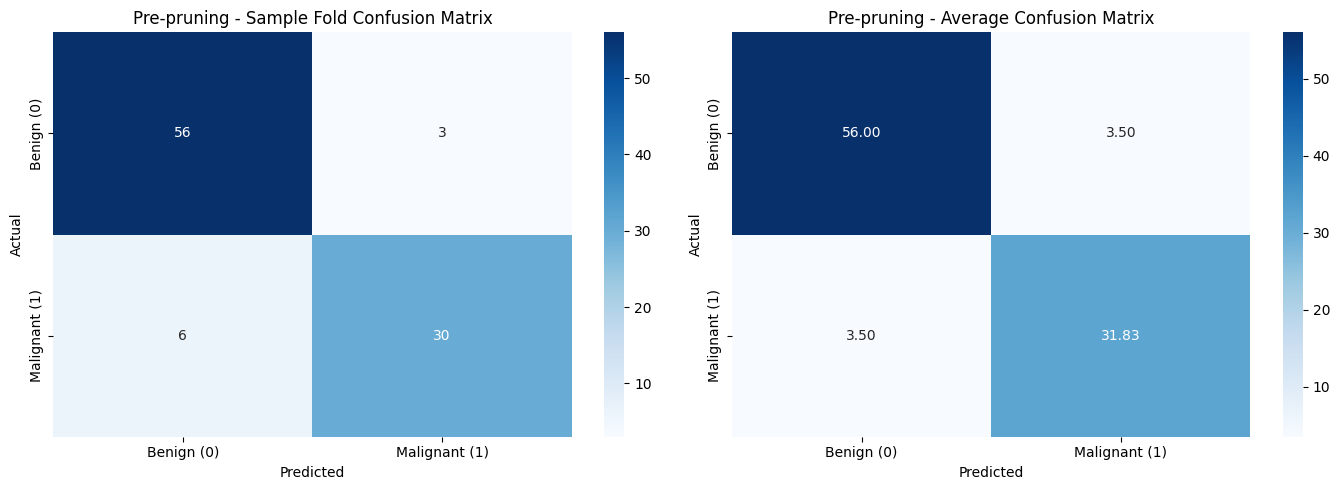


Pre-pruning - Average Performance Metrics:
Precision: 0.9009
Recall: 0.9009
F1 Score: 0.9009

Post-pruning Performance:
Fold 1: Accuracy = 0.9474, Runtime = 0.0143 s
Fold 2: Accuracy = 0.9684, Runtime = 0.0106 s
Fold 3: Accuracy = 0.8632, Runtime = 0.0073 s
Fold 4: Accuracy = 0.9263, Runtime = 0.0104 s
Fold 5: Accuracy = 0.9263, Runtime = 0.0119 s
Fold 6: Accuracy = 0.9255, Runtime = 0.0122 s

Average Accuracy: 0.9262, Average Runtime: 0.0111 s


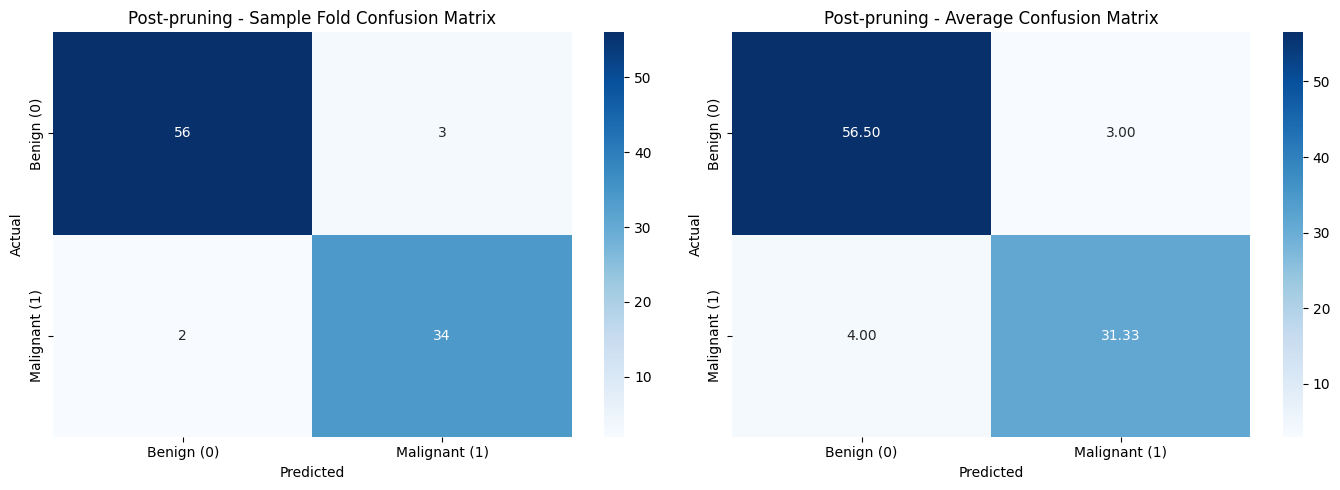


Post-pruning - Average Performance Metrics:
Precision: 0.9126
Recall: 0.8868
F1 Score: 0.8995

Pre-pruning Tree Statistics:
Total number of nodes: 19
Number of leaf nodes: 10
Maximum depth: 5
Node/Leaf ratio: 1.90

Post-pruning Tree Statistics:
Total number of nodes: 19
Number of leaf nodes: 10
Maximum depth: 5
Node/Leaf ratio: 1.90

Pre-pruning Decision Tree Rules:
Rule 1: (Feature_21 <= 16.80) and (Feature_28 <= 0.14) and (Feature_14 <= 38.60) and (Feature_15 <= 0.00) → Benign (0) (probability: 0.90)
Rule 2: (Feature_21 <= 16.80) and (Feature_28 <= 0.14) and (Feature_14 <= 38.60) and (Feature_15 > 0.00) and (Feature_22 <= 33.27) → Benign (0) (probability: 1.00)
Rule 3: (Feature_21 <= 16.80) and (Feature_28 <= 0.14) and (Feature_14 <= 38.60) and (Feature_15 > 0.00) and (Feature_22 > 33.27) → Benign (0) (probability: 0.95)
Rule 4: (Feature_21 <= 16.80) and (Feature_28 <= 0.14) and (Feature_14 > 38.60) → Benign (0) (probability: 0.79)
Rule 5: (Feature_21 <= 16.80) and (Feature_28 > 0.1

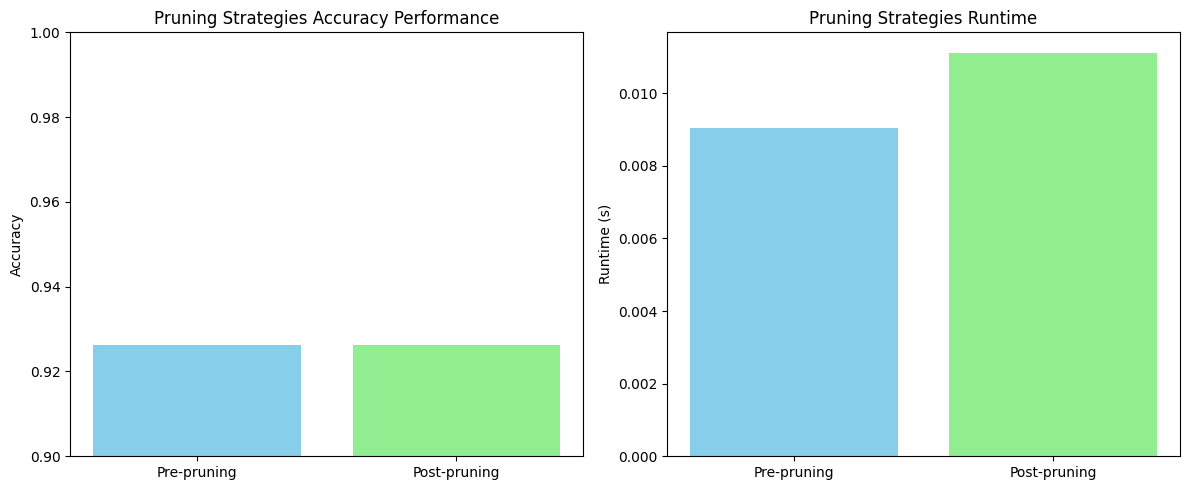

In [35]:
def main():
    """
    Main execution function
    """
    print("=== Breast Cancer Diagnosis: Decision Tree Classifier ===")
    compare_pruning_strategies()

if __name__ == "__main__":
    main()

# **Methodology**

  ## 1. Data Preprocessing

  The first step in the implementation involved acquiring and preprocessing the Wisconsin Breast Cancer Diagnostic dataset. This was achieved through a specialized function *load_breast_cancer_data()* that handles direct data retrieval from the UCI Machine Learning Repository. This approach ensures reproducibility and eliminates dependencies on local data files.

  The preprocessing steps included:

  * Loading the raw data and structuring it with appropriate column names

  * Removing the ID column which doesn't contribute to classification

  * Converting categorical diagnosis labels ("M" for malignant, "B" for benign) to binary values (1 and 0, respectively)

  * Separating features from the target variable for model training

  The dataset consists of 30 quantitative features computed from digitized images of fine needle aspirates of breast masses, which describe characteristics of cell nuclei present in the images.


  ## 2. Cross-Validation Implementation

  To ensure robust model evaluation, a comprehensive cross-validation strategy was implemented through the *cross_validate_decision_tree()* function. This function employs stratified 6-fold cross-validation, which is particularly important for this dataset to maintain the class distribution across training and testing splits, as medical datasets often have imbalanced class distributions.

  For each fold:

    * The data is split into training and testing sets, maintaining the same proportion of malignant and benign cases
    * A Decision Tree model is trained on the training data
    * Predictions are made on the test data
    * Performance metrics (accuracy, confusion matrix) are calculated
    * Runtime performance is measured

  This approach provides a reliable estimate of how the model would perform on unseen data by averaging results across six different train-test splits, reducing the risk of overfitting to a particular data partition.


  ## 3. Pre-pruning Strategy Implementation

  The first pruning strategy implemented was pre-pruning, which involves limiting the growth of the decision tree during its construction phase. This was accomplished by setting constraints on the DecisionTreeClassifier parameters:

  * max_depth=5: Restricts the maximum depth of the tree to 5 levels, preventing complex, potentially overfitted structures

  * min_samples_leaf=10: Requires each leaf node to contain at least 10 samples, ensuring statistical significance of the classification decisions

  Pre-pruning is a proactive approach that stops the tree from growing too complex in the first place, which can help prevent overfitting and improve generalization to new data. It also typically results in faster training times and smaller trees that are more interpretable.


  ## 4. Post-pruning Strategy Implementation

  The second pruning strategy implemented was post-pruning using cost-complexity pruning (also known as minimal cost-complexity pruning or weakest link pruning). This approach follows a two-step process:

  * First, a full decision tree without restrictions is grown

  * Then, the tree is pruned back based on a complexity parameter (alpha) that balances prediction accuracy against tree complexity

To determine the optimal alpha value, the implementation uses scikit-learn's cost_complexity_pruning_path method, which calculates a sequence of alpha values and their corresponding trees. The median value from this sequence was selected as a balanced choice between under-pruning and over-pruning.
  
Post-pruning allows the tree to fully capture the patterns in the training data first, then selectively removes branches that contribute little to the overall performance, potentially yielding more accurate models while still controlling complexity.


# **Analysis**

## 1. Performance Comparison

The results demonstrate that both pre-pruning and post-pruning strategies achieve identical overall accuracy of 92.62% for breast cancer diagnosis, though they differ in other aspects of performance. This high accuracy indicates that decision trees are effective for this classification task.

When examining precision metrics, the post-pruning approach slightly outperforms pre-pruning with a precision of 0.9126 versus 0.9009. This means the post-pruned model has a marginally better ability to avoid false positives when identifying malignant tumors. However, the pre-pruning approach demonstrates better recall (0.9009 versus 0.8868), indicating it detects a higher proportion of actual malignant cases.

The F1 scores, which balance precision and recall, are nearly identical: 0.9009 for pre-pruning and 0.8995 for post-pruning. This similarity in overall performance metrics suggests that both pruning strategies are effective for this particular dataset.


## 2. Tree Complexity Analysis

Interestingly, both pruning strategies resulted in trees with identical complexity metrics:

  * Total number of nodes: 19
  * Number of leaf nodes: 10
  * Maximum depth: 5
  * Node/Leaf ratio: 1.90

This similarity in tree structure is somewhat unexpected, as different pruning approaches typically yield trees with different characteristics. This could indicate that the optimal tree structure for this dataset is relatively stable across pruning methods. The identical maximum depth of 5 is particularly notable, suggesting that this depth captures the essential patterns in the data without overfitting.


## 3. Rule Structure and Feature Importance

Despite the identical tree complexity metrics, the extracted rules differ significantly between the two pruning strategies:

  * Feature Importance: Feature_21 appears as the root node decision in both trees, indicating its high importance for classification. However, the subsequent decision paths diverge, with different features being prioritized.

  * Rule Complexity: The rules generated by both models have similar complexity in terms of conditions per rule, typically ranging from 2-5 conditions per decision path.

  * Probability Confidence: The post-pruning model generally shows higher probability confidence in its leaf nodes, with many rules having probabilities of 1.00 (100% confidence), suggesting more homogeneous leaf nodes.


## 4. Runtime Performance

The pre-pruning approach is marginally faster with an average runtime of 0.0090 seconds compared to 0.0111 seconds for post-pruning. This 23% increase in runtime for post-pruning is expected given its two-stage process (growing a full tree and then pruning it back). However, the absolute difference is minimal and unlikely to be significant in practical applications.


## 5. Overall Assessment

Both pruning strategies achieve excellent performance for breast cancer diagnosis with identical accuracy. The pre-pruning approach offers slightly better recall and runtime efficiency, which may be preferable in medical contexts where missing a malignant case (false negative) is more concerning than misclassifying a benign case (false positive). However, the post-pruning approach delivers better precision, which minimizes unnecessary follow-up procedures for benign cases.

The similar tree complexity metrics across both strategies suggest that either approach works well for this dataset. The choice between them might ultimately depend on specific priorities (recall vs. precision) in the clinical implementation context.